In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 5
# percentage of training set to use as validation
valid_size = 0.1

train_dir = './facenet-resources-master/train_raw'
test_dir = './facenet-resources-master/test_raw'


# convert data to a normalized torch.FloatTensor

train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir,transform=train_transform)
test_data = datasets.ImageFolder(test_dir,transform=test_transform)
print(len(test_data))

78


In [4]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split] 

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx) 
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = train_data.classes

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

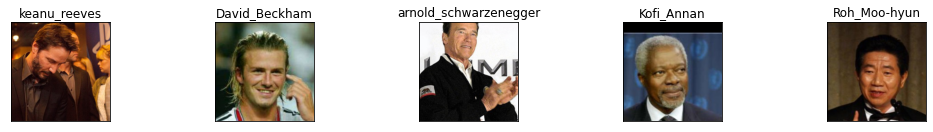

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(5):
    ax = fig.add_subplot(2, 15/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:

from torchvision import models

model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Snow/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

model.classifier[6] = nn.Linear(4096, 19)
if train_on_gpu:
    model.cuda()
model

In [ ]:
#import torch.nn as nn
#import torch.nn.functional as F

## define the CNN architecture
#class Net(nn.Module):
#    def __init__(self):
#        super(Net, self).__init__()
#        # convolutional layer (sees 32x32x3 image tensor)
#        self.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#        # convolutional layer (sees 16x16x16 tensor)
#        self.conv2 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#        # convolutional layer (sees 8x8x32 tensor)
#        self.conv3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#        self.conv4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#        # max pooling layer
#        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#        # linear layer (64 * 32 * 32 -> 5000)
#        self.fc1 = nn.Linear(in_features=9216, out_features=4096, bias=True)
#        # linear layer (500 -> 10)
#        self.fc2 = nn.Linear(in_features=4096, out_features=4096, bias=True)
#        self.fc3 = nn.Linear(in_features=4096, out_features=19, bias=True)
#        # dropout layer (p=0.25)
#        self.dropout = nn.Dropout(p=0.5, inplace=False)
#        self.adap=nn.AdaptiveAvgPool2d(output_size=(6, 6))
#    def forward(self, x):
#        # add sequence of convolutional and max pooling layers
#        x = self.pool(F.relu(self.conv1(x)))
#        x = self.pool(F.relu(self.conv2(x)))
#        x = self.pool(F.relu(self.conv3(x)))
#        x = self.pool(F.relu(self.conv4(x)))
#        x=self.adap(x)
#        # flatten image input
#        x = x.view(-1, 9216)
#        # add dropout layer
#        x = self.dropout(x)
#        # add 1st hidden layer, with relu activation function
#        x = F.relu(self.fc1(x))
#        # add dropout layer
#        x = self.dropout(x)
#        # add 2nd hidden layer, with relu activation function
#        x = F.relu(self.fc2(x))
#        # add dropout layer
#        x = self.dropout(x)
#        # add 2nd hidden layer, with relu activation function
#        x = self.fc3(x)
#        return x

## create a complete CNN
#model = Net()
#print(model)

## move tensors to GPU if CUDA is available
#if train_on_gpu:
#    model.cuda()
#model

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss


In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(19))
class_total = list(0. for i in range(19))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(19):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

 

Test Loss: 1.177803

Test Accuracy of David_Beckham: 100% ( 6/ 6)
Test Accuracy of Guillermo_Coria: 100% ( 4/ 4)
Test Accuracy of John_Negroponte: 100% ( 4/ 4)
Test Accuracy of Kofi_Annan: 100% ( 4/ 4)
Test Accuracy of Megawati_Sukarnoputri: 100% ( 4/ 4)
Test Accuracy of Recep_Tayyip_Erdogan: 75% ( 3/ 4)
Test Accuracy of Roh_Moo-hyun: 100% ( 4/ 4)
Test Accuracy of Silvio_Berlusconi: 100% ( 4/ 4)
Test Accuracy of Tom_Ridge: 75% ( 3/ 4)
Test Accuracy of Vicente_Fox: 100% ( 3/ 3)
Test Accuracy of arnold_schwarzenegger: 20% ( 1/ 5)
Test Accuracy of ben_afflek: 66% ( 2/ 3)
Test Accuracy of dwayne_johnson:  0% ( 0/ 3)
Test Accuracy of elton_john: 80% ( 4/ 5)
Test Accuracy of jerry_seinfeld: 60% ( 3/ 5)
Test Accuracy of kate_beckinsale: 50% ( 1/ 2)
Test Accuracy of keanu_reeves: 33% ( 1/ 3)
Test Accuracy of lauren_cohan:  0% ( 0/ 3)
Test Accuracy of madonna: 60% ( 3/ 5)

Test Accuracy (Overall): 72% (54/75)


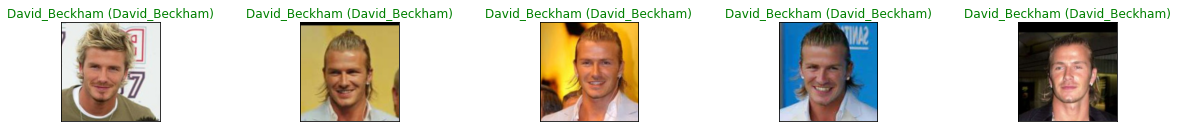

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images.numpy()
# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)  
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in range(len(images)):
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                  color=("green" if preds[idx]==labels[idx].item() else "red"))